<a href="https://colab.research.google.com/github/PunyapaCH/DL_Finalproject/blob/main/6510503522_DeepLearning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bird Species Classification by Sounds**

In [1]:
#@title Libraries
import IPython
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import random
print("labraries imported.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

labraries imported.
Using device: cpu


## Import DATA


---
 ที่มา : https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022


In [2]:
#URL = "https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022?select=Birds+Voice.csv"
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

!kaggle datasets download -d soumendraprasad/sound-of-114-species-of-birds-till-2022

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/soumendraprasad/sound-of-114-species-of-birds-till-2022
License(s): CC0-1.0
100% 2.06G/2.06G [00:20<00:00, 75.9MB/s]
100% 2.06G/2.06G [00:20<00:00, 107MB/s] 


In [3]:
# Unzip dataset
!unzip sound-of-114-species-of-birds-till-2022.zip

Archive:  sound-of-114-species-of-birds-till-2022.zip
  inflating: Birds Voice.csv         
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan10.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan11.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan12.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan13.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan14.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan15.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan16.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan17.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan18.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan19.mp3  
  inflating: Voice of Birds/Voice of Birds/Andean Guan_sound/Andean Guan2.mp3  
  inflating: Voice

## EDA

In [4]:
df_birds = pd.read_csv('Birds Voice.csv')
df_birds.head()

common_name             scientific_name                 recordist_name  \
0  Common Ostrich  Struthio camelus australis                  Frank Lambert   
1  Common Ostrich            Struthio camelus                   Jeremy Hegge   
2  Common Ostrich            Struthio camelus                   Jeremy Hegge   
3  Common Ostrich            Struthio camelus                  Derek Solomon   
4  Common Ostrich            Struthio camelus  Morioka Zoological Park ZOOMO   

  recording_length        Date                                     TYPE  \
0             0:53  2019-10-30                                     call   
1             0:26  2014-11-20                                     call   
2             0:04  2014-11-21                                     call   
3             0:11  2010-02-09                                     call   
4             1:47  2021-09-06  voice during egg laying, zoo collection   

      xc_id   Time       Country                           Download_link  
0  XC516153  08:05  South Africa  https://xeno-canto.org/516153/download  
1  XC208209  04:00  South Africa  https://xeno-canto.org/208209/download  
2  XC208128  06:00  South Africa  https://xeno-canto.org/208128/download  
3   XC46725  07:00  South Africa   https://xeno-canto.org/46725/download  
4  XC675445  17:00         Japan  https://xeno-canto.org/675445/download

In [5]:
df_birds.dtypes

common_name         object
scientific_name     object
recordist_name      object
recording_length    object
Date                object
TYPE                object
xc_id               object
Time                object
Country             object
Download_link       object
dtype: object

In [6]:
print(f"all names count: {df_birds['common_name'].count()}")
print(f"Unique names count: {df_birds['common_name'].nunique()}")

all names count: 2161
Unique names count: 114


Percentage of Null Values:
common_name         0.000000
scientific_name     0.000000
recordist_name      0.000000
recording_length    0.000000
Date                0.000000
TYPE                1.434521
xc_id               0.000000
Time                0.000000
Country             0.000000
Download_link       0.000000
dtype: float64


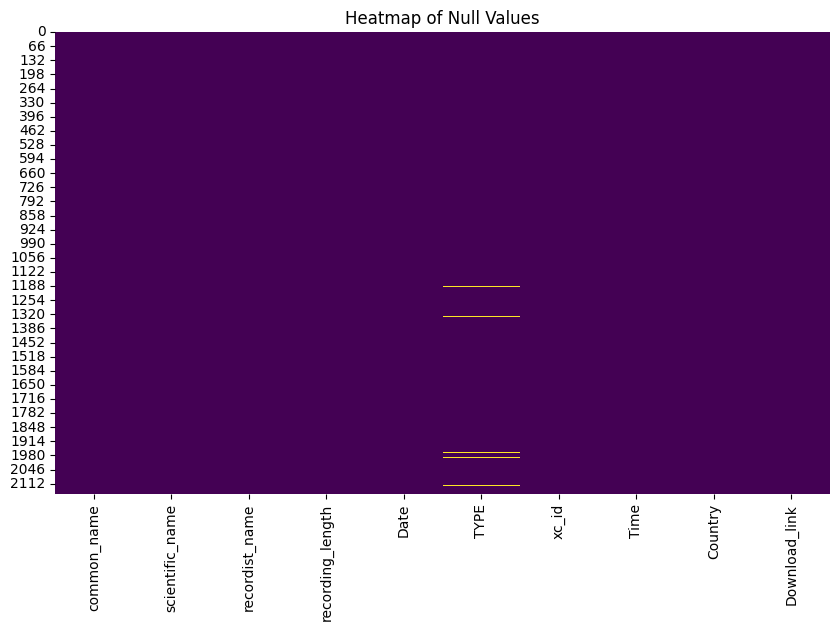

In [7]:
#@title Missing Values
null_percentages = df_birds.isnull().sum() / len(df_birds) * 100
print("Percentage of Null Values:")
print(null_percentages)

plt.figure(figsize=(10, 6))
sns.heatmap(df_birds.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Null Values')
plt.show()

จาก heatmap เราจะเห็นว่า feature ที่เราต้องการใช้ไม่มีค่า null (ใช้แค่ common_name และ download_link)

### Data Example

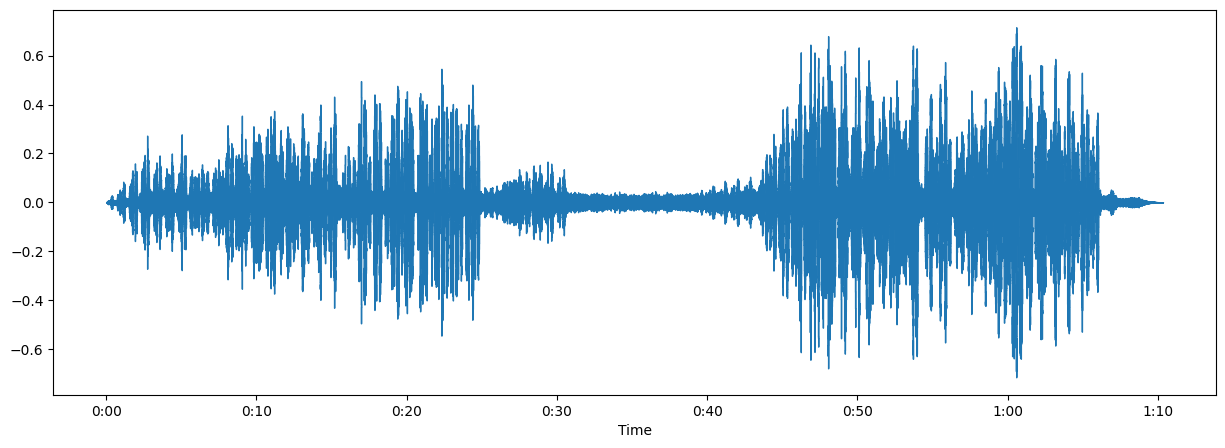

In [8]:
# data sample
plt.figure(figsize=(15,5))

# Load Audio File to extract Audio Data and Sample Rate
audio_data, sample_rate = librosa.load(path='/content/Voice of Birds/Voice of Birds/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca6.mp3')
librosa.display.waveshow(y=audio_data, sr=sample_rate)

# View and Hear Audio File
IPython.display.Audio(data='/content/Voice of Birds/Voice of Birds/Chestnut-winged Chachalaca_sound/Chestnut-winged Chachalaca6.mp3')

In [9]:
sample_rate

22050

In [10]:
audio_data
# bird sound in array form

array([ 8.4533676e-06,  2.1839514e-06, -1.1932570e-06, ...,
        1.5931738e-07, -1.2723283e-06,  4.4954759e-06], dtype=float32)

In [11]:
df= df_birds[["common_name","Download_link"]]
df.head()

common_name                           Download_link
0  Common Ostrich  https://xeno-canto.org/516153/download
1  Common Ostrich  https://xeno-canto.org/208209/download
2  Common Ostrich  https://xeno-canto.org/208128/download
3  Common Ostrich   https://xeno-canto.org/46725/download
4  Common Ostrich  https://xeno-canto.org/675445/download

## Encoding Labels

In [12]:
# Encoding Labels
species_encode = {species: i for i, species in enumerate(df['common_name'].unique())}
int_to_species = {i: species for species, i in species_encode.items()}
df['label'] = df['common_name'].map(species_encode)

df.head()

/tmp/ipython-input-3308079070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['common_name'].map(species_encode)


common_name                           Download_link  label
0  Common Ostrich  https://xeno-canto.org/516153/download      0
1  Common Ostrich  https://xeno-canto.org/208209/download      0
2  Common Ostrich  https://xeno-canto.org/208128/download      0
3  Common Ostrich   https://xeno-canto.org/46725/download      0
4  Common Ostrich  https://xeno-canto.org/675445/download      0

In [13]:
df.sample(5)

common_name                           Download_link  label
873             Huayco Tinamou  https://xeno-canto.org/354370/download     43
97          Northern Cassowary  https://xeno-canto.org/498017/download     11
891             Ornate Tinamou   https://xeno-canto.org/16190/download     45
218              Great Tinamou   https://xeno-canto.org/85067/download     16
1496  Rufous-headed Chachalaca  https://xeno-canto.org/260363/download     83

In [14]:
# Create a mapping from species name to index and vice versa
species_encode = {species: i for i, species in enumerate(df_birds['common_name'].unique())}
int_to_species = {i: species for species, i in species_encode.items()}

print("Species to Index Mapping:")
print(species_encode)

print("\nIndex to Species Mapping:")
print(int_to_species)

Species to Index Mapping:
{'Common Ostrich': 0, 'Somali Ostrich': 1, 'Greater Rhea': 2, 'Lesser Rhea': 3, 'Southern Brown Kiwi': 4, 'North Island Brown Kiwi': 5, 'Okarito Kiwi': 6, 'Little Spotted Kiwi': 7, 'Great Spotted Kiwi': 8, 'Southern Cassowary': 9, 'Dwarf Cassowary': 10, 'Northern Cassowary': 11, 'Emu': 12, 'Grey Tinamou': 13, 'Solitary Tinamou': 14, 'Black Tinamou': 15, 'Great Tinamou': 16, 'White-throated Tinamou': 17, 'Highland Tinamou': 18, 'Tawny-breasted Tinamou': 19, 'Hooded Tinamou': 20, "Berlepsch's Tinamou": 21, 'Cinereous Tinamou': 22, 'Little Tinamou': 23, 'Tepui Tinamou': 24, 'Brown Tinamou': 25, 'Undulated Tinamou': 26, 'Pale-browed Tinamou': 27, 'Brazilian Tinamou': 28, 'Grey-legged Tinamou': 29, 'Red-legged Tinamou': 30, 'Yellow-legged Tinamou': 31, 'Black-capped Tinamou': 32, 'Thicket Tinamou': 33, 'Slaty-breasted Tinamou': 34, 'Choco Tinamou': 35, 'Variegated Tinamou': 36, 'Rusty Tinamou': 37, "Bartlett's Tinamou": 38, 'Small-billed Tinamou': 39, 'Barred Tinam

In [15]:
species_encode["Little Tinamou"]

23

## Train/Validation/Test Split

In [16]:
from sklearn.model_selection import train_test_split

# Identify classes with fewer than 2 samples to avoid errors during stratified split
species_counts_full = df['label'].value_counts()
low_sample_species_full = species_counts_full[species_counts_full < 2].index.tolist()

# Remove rows belonging to low-sample species from the full dataset
df_filtered = df[~df['label'].isin(low_sample_species_full)].copy()

print(f"Original dataset size: {len(df)}")
print(f"Number of species with fewer than 2 samples in full dataset: {len(low_sample_species_full)}")
print(f"Filtered dataset size after initial removal: {len(df_filtered)}")

# Perform the first stratified split (e.g., 70% train, 30% temp)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['label'], random_state=42)

# Identify classes with fewer than 2 samples within temp_df before the second split
species_counts_temp = temp_df['label'].value_counts()
low_sample_species_temp = species_counts_temp[species_counts_temp < 2].index.tolist()

# Remove rows belonging to low-sample species from temp_df
temp_df_filtered = temp_df[~temp_df['label'].isin(low_sample_species_temp)].copy()

print(f"Size of temp_df before filtering: {len(temp_df)}")
print(f"Number of species with fewer than 2 samples in temp_df: {len(low_sample_species_temp)}")
print(f"Size of temp_df after filtering: {len(temp_df_filtered)}")


# Perform the second stratified split on the filtered temp_df (e.g., 50% val, 50% test from the temp_df)
val_df, test_df = train_test_split(temp_df_filtered, test_size=0.5, stratify=temp_df_filtered['label'], random_state=42)


print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Original dataset size: 2161
Number of species with fewer than 2 samples in full dataset: 4
Filtered dataset size after initial removal: 2157
Size of temp_df before filtering: 648
Number of species with fewer than 2 samples in temp_df: 10
Size of temp_df after filtering: 638
Train samples: 1509
Validation samples: 319
Test samples: 319


In [17]:
train_df.head()

common_name                           Download_link  label
256   White-throated Tinamou  https://xeno-canto.org/482161/download     17
2023             Spix's Guan  https://xeno-canto.org/616226/download    105
442        Undulated Tinamou  https://xeno-canto.org/737017/download     26
1867             Marail Guan  https://xeno-canto.org/303410/download     99
1198    Collared Brushturkey  https://xeno-canto.org/140729/download     63

In [18]:
test_df.head()

common_name                           Download_link  label
1123              Puna Tinamou  https://xeno-canto.org/231227/download     57
1608  White-bellied Chachalaca  https://xeno-canto.org/313546/download     87
1625       Speckled Chachalaca  https://xeno-canto.org/443193/download     88
1915            Red-faced Guan  https://xeno-canto.org/273053/download    101
1706      Colombian Chachalaca  https://xeno-canto.org/167583/download     91

In [19]:
val_df.head()

common_name                           Download_link  label
1558  West Mexican Chachalaca  https://xeno-canto.org/274746/download     85
1803             Bearded Guan  https://xeno-canto.org/100877/download     96
568        Red-legged Tinamou   https://xeno-canto.org/57088/download     30
1860              Andean Guan   https://xeno-canto.org/46558/download     98
184             Black Tinamou  https://xeno-canto.org/350134/download     15

## audio-to-MelSpectrogram transformation

In [20]:
from pathlib import Path
import os, re, random
import numpy as np
import torch
import librosa
from torch.utils.data import Dataset
import unicodedata

SAMPLE_RATE = 22050
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048
TIME_STEPS = 128

AUDIO_FOLDER_PATH = Path("./Voice of Birds/Voice of Birds")  # ไม่มี / ท้ายสุด

def norm_text(s: str) -> str:
    """normalize เล็กน้อย: ตัดช่องว่างหัว-ท้าย, ลบ apostrophe/quote, normalize unicode"""
    s = unicodedata.normalize("NFKC", str(s).strip())
    s = s.replace("’", "").replace("'", "")
    return s

class BirdSoundDataset(Dataset):
    def __init__(self, dataframe, audio_dir=AUDIO_FOLDER_PATH,
                 sample_rate=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT,
                 hop_length=HOP_LENGTH, time_steps=TIME_STEPS):

        self.dataframe   = dataframe.copy()
        self.audio_dir   = Path(audio_dir)
        self.sample_rate = sample_rate
        self.n_mels      = n_mels
        self.n_fft       = n_fft
        self.hop_length  = hop_length
        self.time_steps  = time_steps

        # ให้มีคอลัมน์ common_name เสมอ
        if 'common_name' not in self.dataframe.columns:
            self.dataframe = self.dataframe.merge(
                df_birds[['Download_link', 'common_name']], on='Download_link', how='left'
            )

        # เตรียม path ของไฟล์ mp3 สำหรับแต่ละแถว
        file_paths = []
        missing_rows = []
        for i, row in self.dataframe.iterrows():
            common_name = norm_text(row['common_name'])
            # ชื่อโฟลเดอร์ตามของจริง: <common_name>_sound  (ไม่เปลี่ยน space เป็น _)
            species_dir = self.audio_dir / f"{common_name}_sound"

            # หากโฟลเดอร์ไม่มีอยู่ ลอง fallback แบบเดิม (แทนที่ช่องว่างด้วย _ เผื่อบางชนิดตั้งชื่อไว้ต่างไป)
            if not species_dir.is_dir():
                alt_dir = self.audio_dir / f"{common_name.replace(' ', '_')}_sound"
                if alt_dir.is_dir():
                    species_dir = alt_dir

            # หา *.mp3 ทั้งหมดในโฟลเดอร์นั้น
            if species_dir.is_dir():
                mp3s = sorted(str(p) for p in species_dir.glob("*.mp3"))
            else:
                mp3s = []

            if mp3s:
                file_paths.append(mp3s)
            else:
                file_paths.append([])   # เก็บไว้ก่อน เดี๋ยวกรองออก
                missing_rows.append((i, common_name, str(species_dir)))

        # กรองแถวที่ไม่มีไฟล์ออก
        keep_mask = [len(x) > 0 for x in file_paths]
        removed = len(self.dataframe) - sum(keep_mask)
        if removed > 0:
            print(f"Warning: removed {removed} rows with no audio files.")
            # ถ้าอยากตรวจสอบว่าหายตัวไหนบ้าง เปิดบรรทัดด้านล่าง
            # for i, name, spdir in missing_rows[:10]: print("Missing:", name, "expected at", spdir)

        self.dataframe = self.dataframe[keep_mask].reset_index(drop=True)
        self.file_paths = [x for x in file_paths if len(x) > 0]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']

        file_path = random.choice(self.file_paths[idx])  # สุ่ม 1 ไฟล์ในสปีชีส์นั้น
        try:
            audio, sr = librosa.load(file_path, sr=self.sample_rate)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            mel = torch.zeros((1, self.n_mels, self.time_steps))
            return mel, torch.tensor(label, dtype=torch.long)

        mel = librosa.feature.melspectrogram(
            y=audio, sr=self.sample_rate, n_fft=self.n_fft,
            hop_length=self.hop_length, n_mels=self.n_mels
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # pad/trim ให้ยาวเท่ากัน
        T = mel_db.shape[1]
        if T >= self.time_steps:
            mel_proc = mel_db[:, :self.time_steps]
        else:
            pad = self.time_steps - T
            mel_proc = np.pad(mel_db, ((0,0),(0,pad)),
                              mode='constant', constant_values=np.min(mel_db))

        mel_tensor = torch.from_numpy(mel_proc).float().unsqueeze(0)
        return mel_tensor, torch.tensor(label, dtype=torch.long)


In [21]:
# นับจำนวนไฟล์ทั้งหมดที่ระบบจะเห็น
all_mp3 = list(Path("./Voice of Birds/Voice of Birds").glob("*_sound/*.mp3"))
print("Total mp3 files found:", len(all_mp3))
# ดูชนิดที่ไม่มีไฟล์ (ถ้ามี)
# เปิดบรรทัด print ใน __init__ เพื่อไล่ดูชื่อชนิดที่ไม่เจอ

Total mp3 files found: 2161


In [22]:
train_dataset = BirdSoundDataset(train_df, AUDIO_FOLDER_PATH, SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, TIME_STEPS)
val_dataset = BirdSoundDataset(val_df, AUDIO_FOLDER_PATH, SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, TIME_STEPS)
test_dataset = BirdSoundDataset(test_df, AUDIO_FOLDER_PATH, SAMPLE_RATE, N_MELS, N_FFT, HOP_LENGTH, TIME_STEPS)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [23]:
print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in val_dataset: {len(val_dataset)}")

Number of samples in train_dataset: 1509
Number of samples in val_dataset: 319


In [24]:
# Show sample of train_loader
# Get one batch from the train_loader
data_batch, labels_batch = next(iter(train_loader))

print("Shape of Mel Spectrogram batch:", data_batch.shape)
print("Shape of Labels batch:", labels_batch.shape)

# Display a slice of the Mel Spectrogram batch to show numerical values
print("\nSample of Mel Spectrogram data (first sample, first channel, first 5x5 pixels):")
print(data_batch[0, 0, :5, :5].numpy())

# You can optionally print some of the labels
# print("Sample Labels:", labels_batch[:5])

Shape of Mel Spectrogram batch: torch.Size([32, 1, 128, 128])
Shape of Labels batch: torch.Size([32])

Sample of Mel Spectrogram data (first sample, first channel, first 5x5 pixels):
[[-80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80.]
 [-80. -80. -80. -80. -80.]]


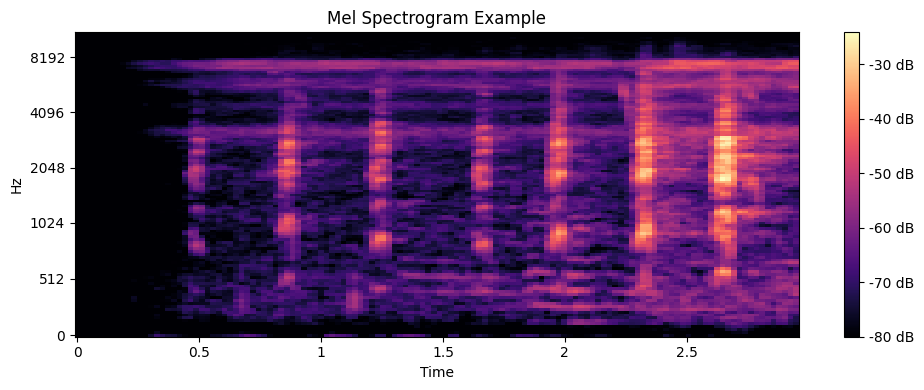

In [25]:
# Plot Mel Spectrogram heatmap for one example
plt.figure(figsize=(10, 4))
librosa.display.specshow(data_batch[0, 0].numpy(), sr=sample_rate, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram Example')
plt.tight_layout()
plt.show()

## CNN Model Architecture

In [ ]:
NUM_CLASSES = len(species_encode) # จำนวนพันธุ์นกทั้งหมด

class BirdClassifierCNN(nn.Module):
    def __init__(self, num_classes, n_mels=128, time_steps=128):
        super(BirdClassifierCNN, self).__init__()

        # 1. Input (1, 128, 128) -> Output (32, 64, 64)
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 2. Input (32, 64, 64) -> Output (64, 32, 32)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 3. Input (64, 32, 32) -> Output (128, 16, 16)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 4. Input (128, 16, 16) -> Output (256, 8, 8)
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # เพิ่ม 256 Channel
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # คำนวณขนาด Flattened size
        # 256 channels * (TIME_STEPS / 16) * (N_MELS / 16)
        # ถ้า N_MELS=128, TIME_STEPS=128: 256 * (128/16) * (128/16) = 256 * 8 * 8 = 16384

        self.fc_input_size = 256 * (time_steps // 16) * (n_mels // 16)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fc_input_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512), # ใช้ BatchNorm1d ก่อน Dropout ใน FC Layer
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

# สร้าง Instance ของโมเดลและกำหนด Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BirdClassifierCNN(NUM_CLASSES).to(DEVICE)

# กำหนด Loss Function และ Optimizer
LEARNING_RATE = 0.001
CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
from torchsummary import summary
# Correct input size should be (channels, height, width) which is (1, N_MELS, TIME_STEPS)
summary(model, (1, N_MELS, TIME_STEPS))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
              ReLU-2         [-1, 32, 128, 128]               0
       BatchNorm2d-3         [-1, 32, 128, 128]              64
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
              ReLU-6           [-1, 64, 64, 64]               0
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
             ReLU-10          [-1, 128, 32, 32]               0
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        MaxPool2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
             ReLU-14          [-1, 256,

## CNN model training

In [ ]:
# ฟังก์ชันสำหรับคำนวณ Accuracy
def calculate_accuracy(y_pred, y_true):
    """Calculates accuracy for a batch"""
    _, predicted = torch.max(y_pred.data, 1)
    correct = (predicted == y_true).sum().item()
    return correct / y_true.size(0)

In [ ]:
from tqdm import tqdm

# Lists สำหรับเก็บค่า Loss และ Accuracy เพื่อวาดกราฟ
train_losses = []
val_losses = []

NUM_EPOCHS = 20

# Training Loop
for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    # ตัวแปรสำหรับแสดงตัวอย่าง
    example_printed = False

    for batch_idx, (data, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(data)
        loss = CRITERION(outputs, labels)

        # Backward and optimize
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()

        # เก็บค่า
        running_loss += loss.item() * data.size(0)
        running_accuracy += calculate_accuracy(outputs, labels) * data.size(0)

        # การแสดงตัวอย่างต่อ Epoch
        if not example_printed:
            # เลือกตัวอย่างแรกของ batch
            sample_output = outputs[0]
            sample_label = labels[0].item()

            _, predicted_idx = torch.max(sample_output.data, 0)
            predicted_specie = int_to_species[predicted_idx.item()]
            actual_specie = int_to_species[sample_label]

            print(f"\n[Epoch {epoch+1} Example] Predicted: {predicted_specie} (Label: {predicted_idx.item()}), Actual: {actual_specie} (Label: {sample_label})")
            example_printed = True

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = running_accuracy / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(data)
            loss = CRITERION(outputs, labels)

            val_loss += loss.item() * data.size(0)
            val_accuracy += calculate_accuracy(outputs, labels) * data.size(0)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_accuracy / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}\n")

print("Training finished!")


Epoch 1 Training:   2%|▏         | 1/48 [00:17<13:48, 17.64s/it]


[Epoch 1 Example] Predicted: White-winged Guan (Label: 104), Actual: Highland Tinamou (Label: 18)


Epoch 1 Training:  42%|████▏     | 20/48 [02:49<03:42,  7.96s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 1 Training: 100%|██████████| 48/48 [06:12<00:00,  7.75s/it]


Epoch 1/20: Train Loss: 4.1286, Train Acc: 0.1564, Val Loss: 3.4150, Val Acc: 0.3009



Epoch 2 Training:   2%|▏         | 1/48 [00:16<13:08, 16.79s/it]


[Epoch 2 Example] Predicted: Grey-headed Chachalaca (Label: 80), Actual: Blue-throated Piping Guan (Label: 111)


Epoch 2 Training:  96%|█████████▌| 46/48 [06:01<00:13,  6.65s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 2 Training: 100%|██████████| 48/48 [06:07<00:00,  7.65s/it]


Epoch 2/20: Train Loss: 3.1357, Train Acc: 0.3148, Val Loss: 3.1457, Val Acc: 0.3166



Epoch 3 Training:   0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 3 Training:   2%|▏         | 1/48 [00:20<15:55, 20.34s/it]


[Epoch 3 Example] Predicted: Dusky-legged Guan (Label: 106), Actual: Plain Chachalaca (Label: 79)


Epoch 3 Training:  23%|██▎       | 11/48 [01:26<04:13,  6.85s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 3 Training:  48%|████▊     | 23/48 [03:01<02:50,  6.82s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 3 Training:  90%

Epoch 3/20: Train Loss: 2.9473, Train Acc: 0.3433, Val Loss: 2.2731, Val Acc: 0.5298



Epoch 4 Training:   2%|▏         | 1/48 [00:22<17:20, 22.15s/it]


[Epoch 4 Example] Predicted: Brushland Tinamou (Label: 47), Actual: Brushland Tinamou (Label: 47)


Epoch 4 Training:  79%|███████▉  | 38/48 [05:01<01:25,  8.52s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 4 Training: 100%|██████████| 48/48 [06:00<00:00,  7.52s/it]


Epoch 4/20: Train Loss: 2.3457, Train Acc: 0.4745, Val Loss: 1.8612, Val Acc: 0.5862



Epoch 5 Training:   2%|▏         | 1/48 [00:16<12:45, 16.29s/it]


[Epoch 5 Example] Predicted: Southern Cassowary (Label: 9), Actual: Andean Guan (Label: 98)


Epoch 5 Training: 100%|██████████| 48/48 [05:59<00:00,  7.50s/it]


Epoch 5/20: Train Loss: 1.9662, Train Acc: 0.5500, Val Loss: 1.4135, Val Acc: 0.7179



Epoch 6 Training:   2%|▏         | 1/48 [00:16<12:51, 16.42s/it]


[Epoch 6 Example] Predicted: White-winged Guan (Label: 104), Actual: White-winged Guan (Label: 104)


Epoch 6 Training:  21%|██        | 10/48 [01:29<06:00,  9.48s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 6 Training:  35%|███▌      | 17/48 [02:22<04:08,  8.00s/it]/tmp/ipython-input-393

Epoch 6/20: Train Loss: 1.7166, Train Acc: 0.5997, Val Loss: 1.1051, Val Acc: 0.7806



Epoch 7 Training:   2%|▏         | 1/48 [00:17<14:02, 17.93s/it]


[Epoch 7 Example] Predicted: Melanesian Megapode (Label: 75), Actual: Melanesian Megapode (Label: 75)


Epoch 7 Training: 100%|██████████| 48/48 [05:57<00:00,  7.44s/it]


Epoch 7/20: Train Loss: 1.3271, Train Acc: 0.6991, Val Loss: 0.8304, Val Acc: 0.8401



Epoch 8 Training:   2%|▏         | 1/48 [00:19<14:53, 19.00s/it]


[Epoch 8 Example] Predicted: Cauca Guan (Label: 103), Actual: Cauca Guan (Label: 103)


Epoch 8 Training:  77%|███████▋  | 37/48 [04:57<01:27,  7.94s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 8 Training: 100%|██████████| 48/48 [05:58<00:00,  7.46s/it]
/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Epoch 8/20: Train Loss: 1.0972, Train Acc: 0.7462, Val Loss: 0.8878, Val Acc: 0.8056



Epoch 9 Training:   2%|▏         | 1/48 [00:19<15:12, 19.41s/it]


[Epoch 9 Example] Predicted: Black-capped Tinamou (Label: 32), Actual: Black-capped Tinamou (Label: 32)


Epoch 9 Training:   8%|▊         | 4/48 [00:40<06:13,  8.49s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 9 Training: 100%|██████████| 48/48 [06:05<00:00,  7.60s/it]


Epoch 9/20: Train Loss: 0.9646, Train Acc: 0.7886, Val Loss: 0.5676, Val Acc: 0.9091



Epoch 10 Training:   2%|▏         | 1/48 [00:19<15:19, 19.56s/it]


[Epoch 10 Example] Predicted: Great Tinamou (Label: 16), Actual: Great Tinamou (Label: 16)


/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 10 Training:  62%|██████▎   | 30/48 [03:57<02:21,  7.89s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 10 Training: 100%|██████████| 48/48 [06:08<00:00,  7.67s/it]
/tmp/ipython-input-

Epoch 10/20: Train Loss: 0.8334, Train Acc: 0.8105, Val Loss: 0.4508, Val Acc: 0.9154



Epoch 11 Training:   2%|▏         | 1/48 [00:19<14:55, 19.05s/it]


[Epoch 11 Example] Predicted: Red-faced Guan (Label: 101), Actual: Crested Guan (Label: 102)


Epoch 11 Training:  10%|█         | 5/48 [00:57<07:21, 10.26s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 11 Training:  69%|██████▉   | 33/48 [04:34<01:54,  7.60s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 11 Training:  7

Epoch 11/20: Train Loss: 0.6637, Train Acc: 0.8595, Val Loss: 0.4766, Val Acc: 0.8934



Epoch 12 Training:   2%|▏         | 1/48 [00:20<16:17, 20.81s/it]


[Epoch 12 Example] Predicted: White-throated Tinamou (Label: 17), Actual: White-throated Tinamou (Label: 17)


Epoch 12 Training: 100%|██████████| 48/48 [05:54<00:00,  7.39s/it]


Epoch 12/20: Train Loss: 0.6558, Train Acc: 0.8588, Val Loss: 0.3937, Val Acc: 0.9154



Epoch 13 Training:   2%|▏         | 1/48 [00:19<15:36, 19.92s/it]


[Epoch 13 Example] Predicted: Speckled Chachalaca (Label: 88), Actual: Speckled Chachalaca (Label: 88)


/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 13 Training: 100%|██████████| 48/48 [06:01<00:00,  7.53s/it]
/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audiorea

Epoch 13/20: Train Loss: 0.5587, Train Acc: 0.8675, Val Loss: 0.3395, Val Acc: 0.9404



Epoch 14 Training:   2%|▏         | 1/48 [00:25<19:59, 25.52s/it]


[Epoch 14 Example] Predicted: Blue-throated Piping Guan (Label: 111), Actual: Blue-throated Piping Guan (Label: 111)


Epoch 14 Training:  15%|█▍        | 7/48 [01:05<05:23,  7.90s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 14 Training: 100%|██████████| 48/48 [06:03<00:00,  7.57s/it]


Epoch 14/20: Train Loss: 0.5307, Train Acc: 0.8801, Val Loss: 0.3049, Val Acc: 0.9342



Epoch 15 Training:   2%|▏         | 1/48 [00:17<14:00, 17.89s/it]


[Epoch 15 Example] Predicted: Crested Guan (Label: 102), Actual: Crested Guan (Label: 102)


Epoch 15 Training: 100%|██████████| 48/48 [05:49<00:00,  7.27s/it]


Epoch 15/20: Train Loss: 0.4352, Train Acc: 0.9059, Val Loss: 0.2537, Val Acc: 0.9436



Epoch 16 Training:   2%|▏         | 1/48 [00:17<13:26, 17.17s/it]


[Epoch 16 Example] Predicted: Marail Guan (Label: 99), Actual: Marail Guan (Label: 99)


Epoch 16 Training:  38%|███▊      | 18/48 [02:24<03:10,  6.35s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 16 Training:  81%|████████▏ | 39/48 [05:09<01:10,  7.86s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 16 Training: 1

Epoch 16/20: Train Loss: 0.4046, Train Acc: 0.9085, Val Loss: 0.3546, Val Acc: 0.9279



Epoch 17 Training:   0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 17 Training:   2%|▏         | 1/48 [00:19<15:17, 19.52s/it]


[Epoch 17 Example] Predicted: Grey-headed Chachalaca (Label: 80), Actual: Grey-headed Chachalaca (Label: 80)


Epoch 17 Training:  12%|█▎        | 6/48 [00:57<06:02,  8.63s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 17 Training:  21%|██        | 10/48 [01:34<05:22,  8.49s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 17 Training: 10

Epoch 17/20: Train Loss: 0.3501, Train Acc: 0.9291, Val Loss: 0.2000, Val Acc: 0.9561



Epoch 18 Training:   2%|▏         | 1/48 [00:18<14:28, 18.48s/it]


[Epoch 18 Example] Predicted: Buff-browed Chachalaca (Label: 94), Actual: Buff-browed Chachalaca (Label: 94)


Epoch 18 Training:  67%|██████▋   | 32/48 [04:15<01:42,  6.41s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 18 Training: 100%|██████████| 48/48 [05:54<00:00,  7.39s/it]


Epoch 18/20: Train Loss: 0.2973, Train Acc: 0.9317, Val Loss: 0.2321, Val Acc: 0.9404



Epoch 19 Training:   2%|▏         | 1/48 [00:22<17:55, 22.88s/it]


[Epoch 19 Example] Predicted: White-winged Guan (Label: 104), Actual: White-winged Guan (Label: 104)


Epoch 19 Training:  15%|█▍        | 7/48 [01:04<05:31,  8.07s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 19 Training:  29%|██▉       | 14/48 [02:04<04:57,  8.74s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 19 Training:  5

Epoch 19/20: Train Loss: 0.3234, Train Acc: 0.9245, Val Loss: 0.2255, Val Acc: 0.9530



Epoch 20 Training:   2%|▏         | 1/48 [00:17<13:54, 17.76s/it]


[Epoch 20 Example] Predicted: Tawny-breasted Tinamou (Label: 19), Actual: Tawny-breasted Tinamou (Label: 19)


Epoch 20 Training:  40%|███▉      | 19/48 [02:32<03:45,  7.79s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 20 Training:  44%|████▍     | 21/48 [02:46<03:17,  7.31s/it]/tmp/ipython-input-3934155011.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.sample_rate)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 20 Training:  

Epoch 20/20: Train Loss: 0.2922, Train Acc: 0.9370, Val Loss: 0.1934, Val Acc: 0.9498

Training finished!


## Evaluation

Testing: 100%|██████████| 10/10 [01:06<00:00,  6.60s/it]



Final Test Loss: 0.2408
--- Evaluation Metrics ---
Accuracy: 95.30
Precision (Macro): 92.95
Recall (Macro): 92.45
F1 Score (Macro): 91.96


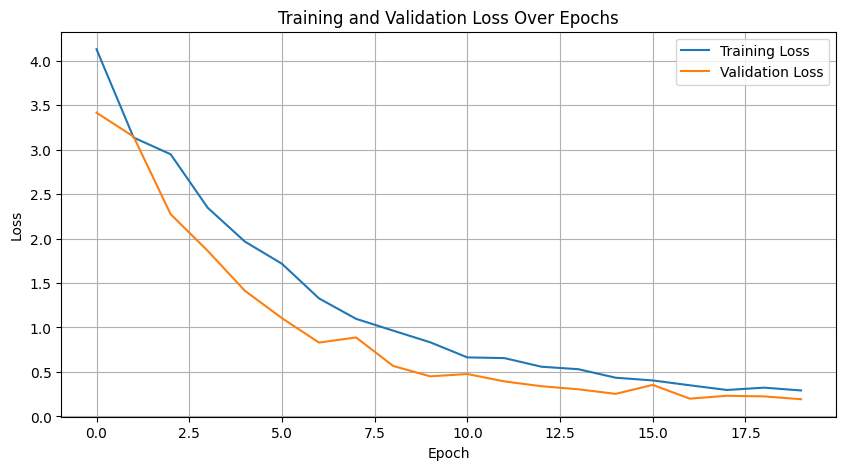

In [ ]:
model.eval()
all_predictions = []
all_targets = []
test_loss = 0.0

with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Testing"):
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(data)
        loss = CRITERION(outputs, labels)

        test_loss += loss.item() * data.size(0)

        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

final_test_loss = test_loss / len(test_dataset)
print(f"\nFinal Test Loss: {final_test_loss:.4f}")

# คำนวณ Metrics
accuracy = accuracy_score(all_targets, all_predictions)*100
precision = precision_score(all_targets, all_predictions, average='macro', zero_division=0)*100
recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)*100
f1 = f1_score(all_targets, all_predictions, average='macro', zero_division=0)*100

print("--- Evaluation Metrics ---")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Macro): {precision:.2f}")
print(f"Recall (Macro): {recall:.2f}")
print(f"F1 Score (Macro): {f1:.2f}")

# Training/Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()